In [44]:
%matplotlib inline

In [45]:
import numpy as np
import astropy.io.fits as pf
import matplotlib
from matplotlib import pyplot as plt

In [46]:
# Import the reduced .fits file for Tabby's star

apf_reduced = pf.open('ramp.194.fits copy')
reduced_image_fits = apf_reduced[0].data

# get the wavelength values for the reduced data file

wave = pf.open('apf_wave.fits copy')
wave_values = wave[0].data

In [47]:
# identify and remove cosmic rays

def id_and_remove(patch_1D):
    plt.figure(figsize=(5,5))
    plt.subplot(2,1,1)
    plt.plot(patch_1D, color = 'b', marker = 'o')
    for i in range(5, patch_1D.size - 5):
        if ((patch_1D[i]>patch_1D[i-1]) and (patch_1D[i]>patch_1D[i+1]) and (patch_1D[i]>(bias*1.25))
            and (patch_1D[i-3]<=(bias*1.25)) and (patch_1D[i+3]<=(bias*1.25))):
            half_max = ((patch_1D[i]) + (patch_1D[i+5] + patch_1D[i-5])/2)/2
            left_side = np.where(patch_1D[:i] <= half_max)
            left_mark = left_side[0][-1]
            right_side = np.where(patch_1D[i:] <= half_max)
            right_mark = right_side[0][0] + i
            peak_x = (right_mark + left_mark)/2
            for x in range(left_mark,right_mark+1):
                plt.plot(x,patch_1D[x], color = 'r', marker = 'o')
            plt.axvline(x=peak_x, ymin = np.min(patch_1D) - 1000, color = 'r', linestyle = '-.')
            plt.axhline(y=half_max, xmin = 0, color = 'r', linestyle = '-.')
            plt.legend(['signal', 'cosmic ray'], loc='best')
            plt.ylim(0,4500)
            plt.title('Cosmic Ray')
         
    edited_patch = patch_1D.copy()
 
    for i in range(5, patch_1D.size - 5):
        if ((patch_1D[i]>patch_1D[i-1]) and (patch_1D[i]>patch_1D[i+1]) and (patch_1D[i]>(bias*1.25))
            and (patch_1D[i-3]<=(bias*1.25)) and (patch_1D[i+3]<=(bias*1.25))):
                half_max = ((patch_1D[i]) + (patch_1D[i+5] + patch_1D[i-5])/2)/2
                left_side = np.where(patch_1D[:i] <= half_max)
                left_mark = left_side[0][-1]
                right_side = np.where(patch_1D[i:] <= half_max)
                right_mark = right_side[0][0] + i
                peak_x = (right_mark + left_mark)/2
                left = np.arange(left_mark-5,left_mark)
                right = np.arange(right_mark+1,right_mark+6)
                x_values = np.concatenate((left,right))
                for x in range(left_mark,right_mark+1):
                     edited_patch[x] = np.interp(x, x_values, patch_1D[x_values])
 
    plt.figure(figsize=(5,5))
    plt.subplot(2,1,2)
    plt.plot(edited_patch, color = 'b', marker = 'o')
    plt.ylim(0,4500)
    plt.title('Cosmic Ray Removed')

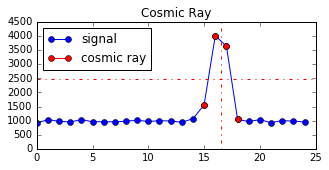

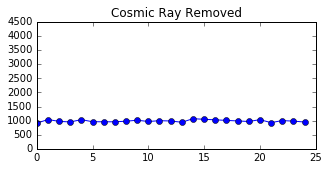

In [48]:
id_and_remove(reduced_image_fits[53, 3050:3075])

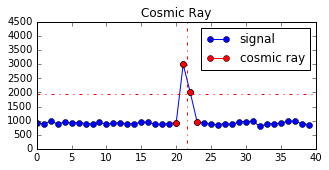

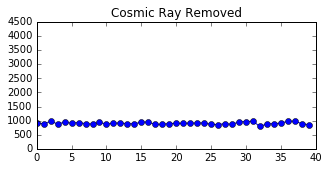

In [49]:
id_and_remove(reduced_image_fits[53, 3280:3320])

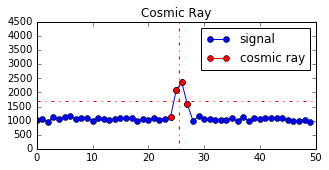

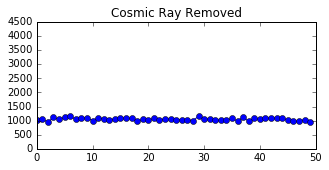

In [50]:
id_and_remove(reduced_image_fits[53, 2750:2800])

In [51]:
# identify cosmic rays, delete them and replace with interpolated data point
# is this the right methodology for identifying cosmic rays?
# is straight line interpolation the best way to remove cosmic rays?

def cosmic_ray_remove(patch_1D):
    edited_patch = patch_1D.copy()
    for i in range(5, patch_1D.size - 5):
        if ((patch_1D[i]>patch_1D[i-1]) and (patch_1D[i]>patch_1D[i+1]) and (patch_1D[i]>(bias*1.25))
            and (patch_1D[i-3]<=(bias*1.25)) and (patch_1D[i+3]<=(bias*1.25))):
                half_max = ((patch_1D[i]) + (patch_1D[i+5] + patch_1D[i-5])/2)/2
                left_side = np.where(patch_1D[:i] <= half_max)
                left_mark = left_side[0][-1]
                right_side = np.where(patch_1D[i:] <= half_max)
                right_mark = right_side[0][0] + i
                peak_x = (right_mark + left_mark)/2
                left = np.arange(left_mark-5,left_mark)
                right = np.arange(right_mark+1,right_mark+6)
                x_values = np.concatenate((left,right))
                for x in range(left_mark,right_mark+1):
                     edited_patch[x] = np.interp(x, x_values, patch_1D[x_values])
    return edited_patch

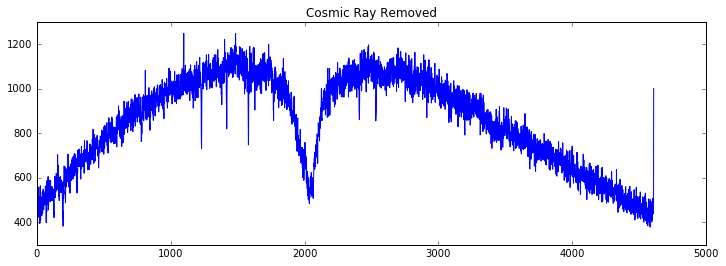

In [52]:
# Remove cosmic ray from a chosen spectral order

test = cosmic_ray_remove(reduced_image_fits[53])

plt.figure(figsize=(12,4))
plt.plot(test, color = 'b')
plt.title('Cosmic Ray Removed')

In [53]:
# Normalization function
# Is polyfit the best function to fit to the curve?

def polynfit(order_1D):
    x = np.arange(0,4608)
    coeffs = np.polyfit(x,order_1D, 3)
    polynomial = np.poly1d(coeffs)
    return polynomial

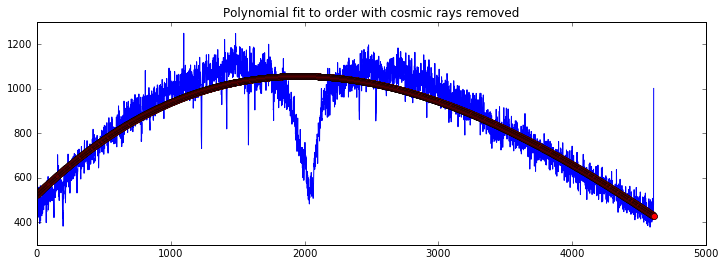

In [54]:
# Show curve overlaid on spectral order

polynomial = polynfit(reduced_image_fits[53])

plt.figure(figsize=(12,4))
plt.plot(test, color = 'b')
for x in range(4608):
    plt.plot(x, polynomial[0] + polynomial[1]*x + polynomial[2]*x**2 + polynomial[3]*x**3 + polynomial[4]*x**4, marker = 'o', color = 'r')
plt.title('Polynomial fit to order with cosmic rays removed')

In [55]:
# Define normalization function
# Divide spectral order by polynomial

def normalize(order_1D):
    x = np.arange(0,4608)
    coeffs = np.polyfit(x,order_1D, 3)
    polynomial = np.poly1d(coeffs)
    normalized_order = np.zeros(4608)
    for i in range(4608):
        normalized_order[i] = order_1D[i]/polynomial(i)
    return normalized_order

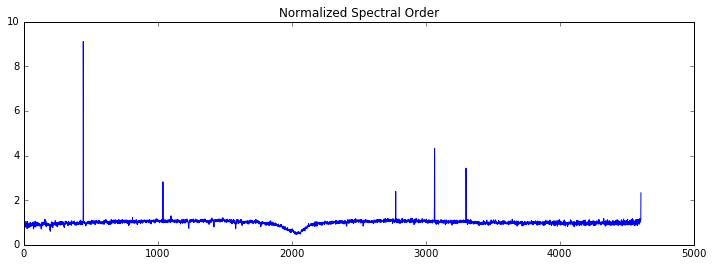

In [56]:
#  Plot the normalized spectral order

plt.figure(figsize=(12,4))
plt.plot(normalize(reduced_image_fits[53]), color = 'b')
plt.title('Normalized Spectral Order')

363953
363953


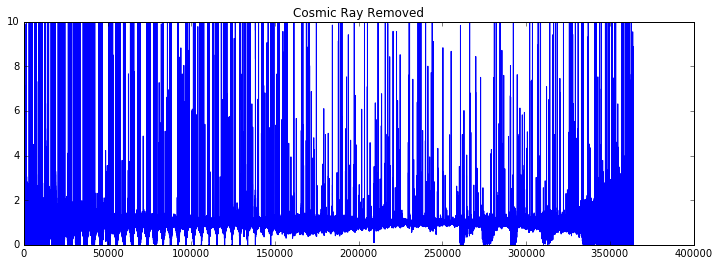

In [58]:
# Convert 2-D spectrum into one continuous 1-D spectrum and then normalize
# 79 x 4608 array
# Have to get rid of the 4608th data point because every 4608th data point has same value

# Taking a copy of the reduced fits file
# Remove cosmic rays from each order
# Normalize each order
# Stitch the normalized order together into a 1D spectrum

spectrum_2D = np.zeros((79,4607))
wavelength = wave_values.ravel()
reduced_file = reduced_image_fits.copy()

for i in range(79):
    cosmic_ray_remove(reduced_file[i])
    normalized_order = normalize(reduced_file[i])
    spectrum_2D[i,:4607] = normalized_order[:4607]

spectrum_1D = spectrum_2D.ravel()

# print(wavelength.size)
# print(spectrum_1D.size)

plt.figure(figsize=(12,4))
#plt.plot(wavelength, spectrum_1D, color = 'b')
plt.plot(spectrum_1D, color = 'b')
plt.ylim(0,10)
plt.title('Cosmic Ray Removed')